# Monthly Electricity Time Series Analysis

Dataset Name: Monthly Electricity Statistics (MES_0125.csv)<br>
Source: International Energy Agency (IEA)<br>
URL: https://www.iea.org/data-and-statistics/data-product/monthly-electricity-statistics<br>
Problem Type: Regression (Time Series Forecasting)

-This analysis aims to forecast monthly electricity [consumption/production] based on historical time series data.<br>
-Accurate electricity forecasting is crucial for energy planning, grid management, and policy development.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGBRegressor

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
# Set display options
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Data Loading and Initial Exploration

In [ ]:
# Load the dataset
file_path = r'E:\ML\data\MES_0125.csv'  # Adjust path as needed

try:
    df = pd.read_csv(file_path, encoding='latin-1', skiprows=8)
    print(f"Dataset loaded successfully with shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head(5))
except Exception as e:
    print(f"Error loading data: {e}")

Dataset loaded successfully with shape: (149113, 6)

First 5 rows:
     Country          Time                     Balance  \
0  Australia  January 2025  Net Electricity Production   
1  Australia  January 2025  Net Electricity Production   
2  Australia  January 2025  Net Electricity Production   
3  Australia  January 2025  Net Electricity Production   
4  Australia  January 2025  Net Electricity Production   

                             Product       Value Unit  
0                        Electricity  24339.7201  GWh  
1                              Hydro    934.8261  GWh  
2            Total Combustible Fuels  13845.2112  GWh  
3  Coal, Peat and Manufactured Gases   9948.2225  GWh  
4         Oil and Petroleum Products    318.1188  GWh  


## 2. Data Preprocessing and Cleaning

In [4]:
def prepare_time_series_data(df):
    # Process the date column
    date_cols = [col for col in df.columns if any(x in col.lower() for x in 
                ['date', 'time', 'month', 'year', 'period'])]
    
    if date_cols:
        date_col = date_cols[0]
        print(f"Using '{date_col}' as date column")
    else:
        print("No date column found, creating one")
        df['Date'] = pd.date_range(start='2000-01-01', periods=len(df), freq='MS')
        date_col = 'Date'
    
    # Convert to datetime and set as index
    try:
        df[date_col] = pd.to_datetime(df[date_col])
    except:
        date_formats = ['%Y-%m-%d', '%d-%m-%Y', '%m/%d/%Y', '%Y/%m/%d', '%b %Y', '%Y-%m', '%m-%Y']
        for fmt in date_formats:
            try:
                df[date_col] = pd.to_datetime(df[date_col], format=fmt)
                break
            except:
                continue
    
    df = df.set_index(date_col).sort_index()
    
    # Finding the target variable
    electricity_cols = [col for col in df.columns if any(x in str(col).lower() for x in 
                       ['electricity', 'power', 'energy', 'consumption', 'production', 'kwh', 'mwh', 'gwh'])]
    
    if electricity_cols:
        target_col = electricity_cols[0]
    else:
        numeric_cols = df.select_dtypes(include=['number']).columns
        if len(numeric_cols) > 0:
            target_col = numeric_cols[0]
            print(f"Using first numeric column '{target_col}' as target")
        else:
            raise ValueError("No suitable target column found")
    
    print(f"Using '{target_col}' as target variable")
    
    # Handle missing values
    if df.isnull().sum().sum() > 0:
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
        print("Missing values handled with interpolation")
    
    # Handle outliers in target variable
    q1 = df[target_col].quantile(0.25)
    q3 = df[target_col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]
    if len(outliers) > 0:
        print(f"Found {len(outliers)} outliers in {target_col}")
        # Use rolling median to smooth outliers
        df[target_col + '_smoothed'] = df[target_col].rolling(window=3, center=True).median().fillna(df[target_col])
        mask = (df[target_col] < lower_bound) | (df[target_col] > upper_bound)
        df.loc[mask, target_col] = df.loc[mask, target_col + '_smoothed']
        df = df.drop(target_col + '_smoothed', axis=1)
    
    # Feature Engineering
    # Add date-based features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    
    # Add cyclical encoding for month
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    
    # Add lag features
    for lag in [1, 3, 6, 12]:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Add rolling statistics
    for window in [3, 6, 12]:
        df[f'{target_col}_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean().shift(1)
    
    # Add difference features
    df[f'{target_col}_diff_12'] = df[target_col].diff(12)
    
    # Remove rows with NaN from lag features
    df = df.dropna()
    
    return df, target_col

In [5]:
# Processing the data
df, target_column = prepare_time_series_data(df)
print(f"\nProcessed data shape: {df.shape}")

Using 'Time' as date column
Using first numeric column 'Value' as target
Using 'Value' as target variable
Missing values handled with interpolation
Found 24246 outliers in Value

Processed data shape: (149101, 18)


## 3. Exploratory Data Analysis (EDA)

In [6]:
def perform_time_series_eda(df, target_col):
    # Plot the full time series
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[target_col])
    plt.title(f'Monthly {target_col} Over Time')
    plt.grid(True)
    plt.show()
    
    # Plot rolling statistics
    rolling_mean = df[target_col].rolling(window=12).mean()
    rolling_std = df[target_col].rolling(window=12).std()
    
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[target_col], label='Original')
    plt.plot(df.index, rolling_mean, label='Rolling Mean (12m)')
    plt.plot(df.index, rolling_std, label='Rolling Std (12m)')
    plt.title(f'Rolling Statistics for {target_col}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Seasonal decomposition if we have enough data
    if len(df) >= 24:
        try:
            decomposition = seasonal_decompose(df[target_col], model='additive', period=12)
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
            ax1.plot(df.index, df[target_col])
            ax1.set_title('Original')
            ax2.plot(decomposition.trend)
            ax2.set_title('Trend')
            ax3.plot(decomposition.seasonal)
            ax3.set_title('Seasonality')
            ax4.plot(decomposition.resid)
            ax4.set_title('Residuals')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error in seasonal decomposition: {e}")
    
    # ACF and PACF plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(df[target_col].dropna(), lags=36, ax=ax1)
    plot_pacf(df[target_col].dropna(), lags=36, ax=ax2)
    plt.tight_layout()
    plt.show()
    
    # Check stationarity
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(df[target_col].dropna())
    print('\nAugmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')

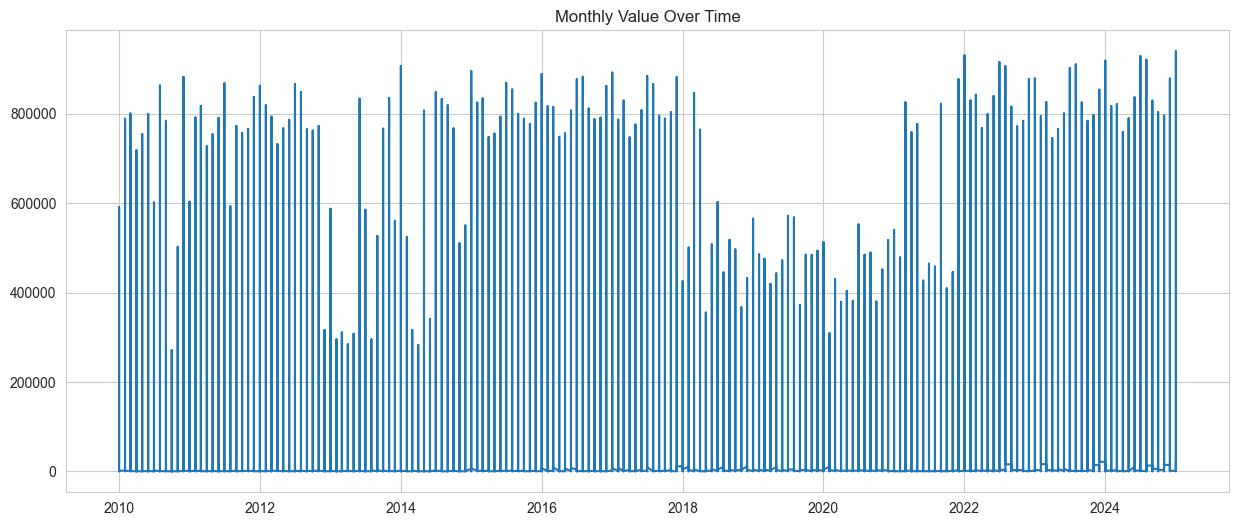

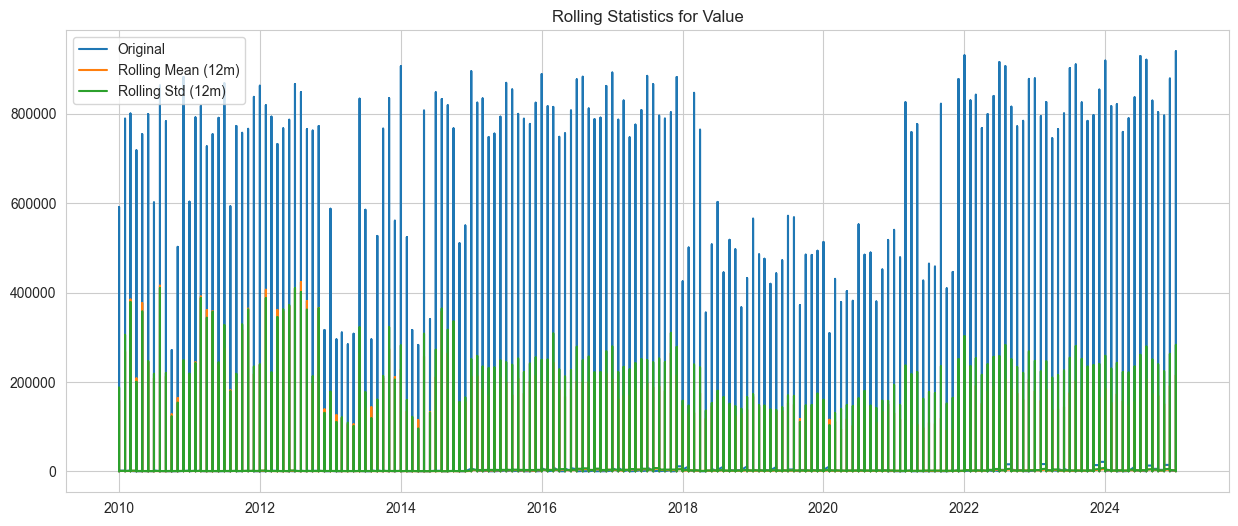

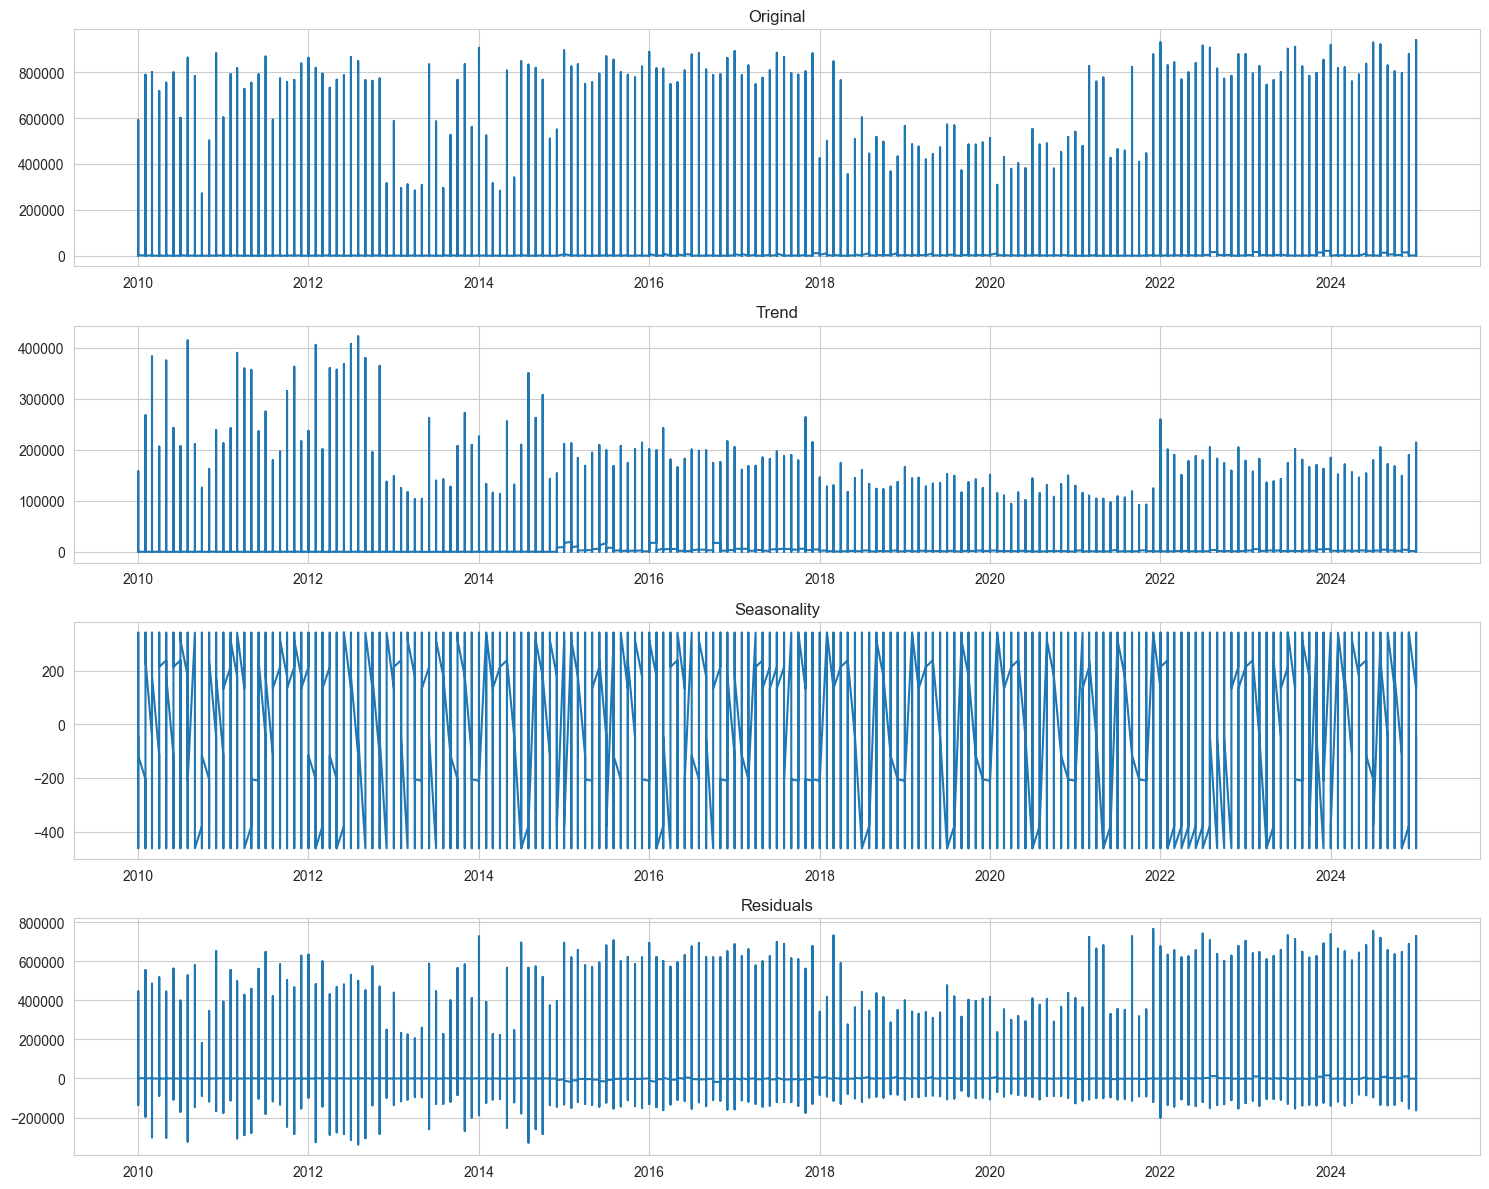

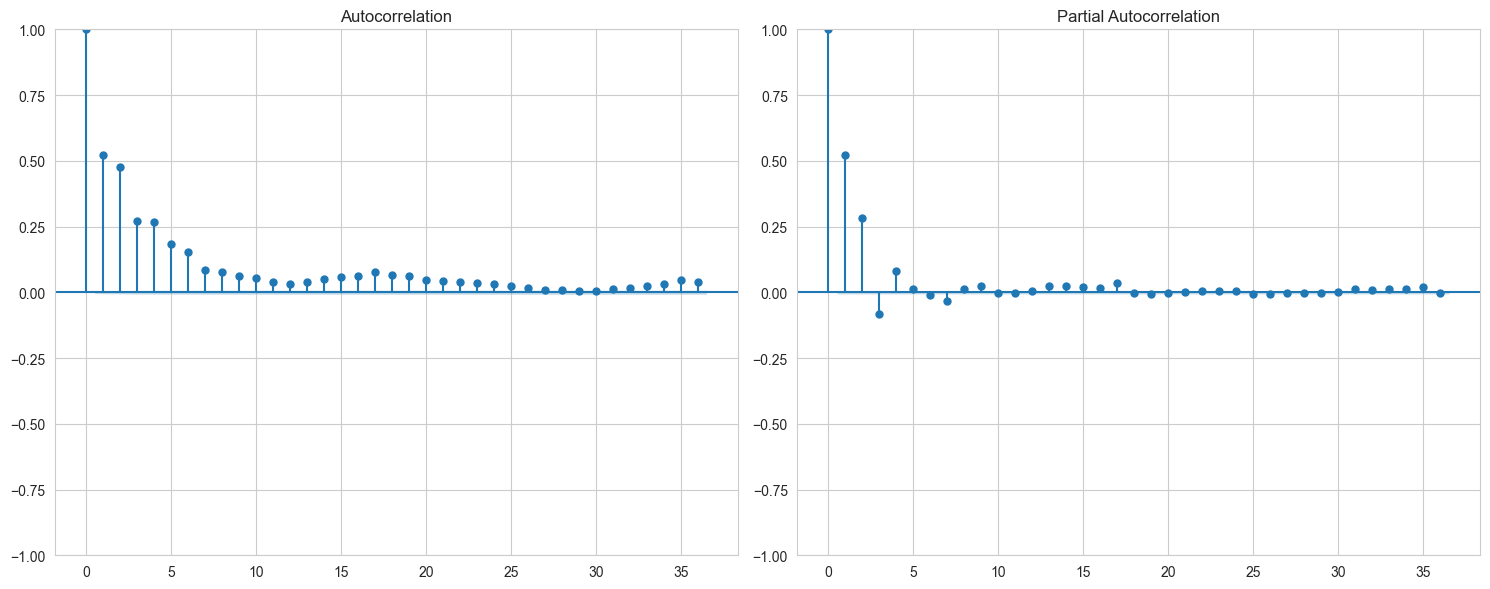


Augmented Dickey-Fuller Test Results:
ADF Statistic: -31.5390
p-value: 0.0000
Stationary


In [7]:
# Perform EDA
perform_time_series_eda(df, target_column)

## 4. Model Preparation - Train/Test Split


Train data: (119280, 18) (2010-01-01 00:00:00 to 2022-01-01 00:00:00)
Test data: (29821, 18) (2022-01-01 00:00:00 to 2025-01-01 00:00:00)
Found categorical columns: ['Country', 'Balance', 'Product', 'Unit']
After encoding: 88 features


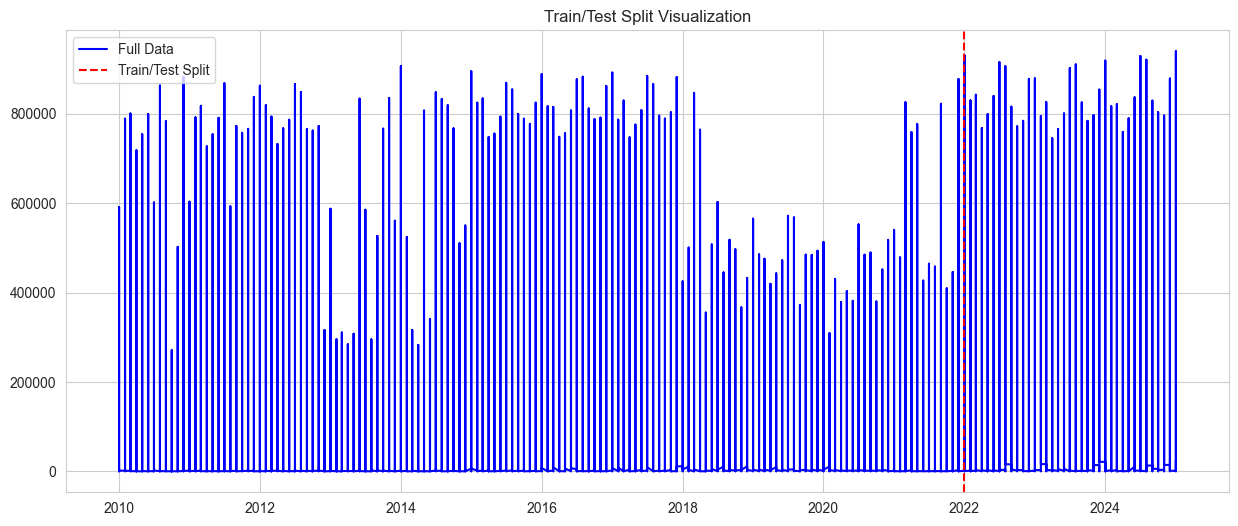

In [8]:
def prepare_train_test_data(df, target_col, test_size=0.2):
    # Split data chronologically
    train_size = int(len(df) * (1 - test_size))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]
    
    print(f"\nTrain data: {train_data.shape} ({train_data.index.min()} to {train_data.index.max()})")
    print(f"Test data: {test_data.shape} ({test_data.index.min()} to {test_data.index.max()})")
    
    # Split features and target
    X_train = train_data.drop(target_col, axis=1)
    y_train = train_data[target_col]
    X_test = test_data.drop(target_col, axis=1)
    y_test = test_data[target_col]
    
    # Handle categorical variables
    cat_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()
    if cat_cols:
        print(f"Found categorical columns: {cat_cols}")
        X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
        X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
        
        for col in X_train_encoded.columns:
            if col not in X_test_encoded.columns:
                X_test_encoded[col] = 0
        X_test_encoded = X_test_encoded[X_train_encoded.columns]
        
        X_train = X_train_encoded
        X_test = X_test_encoded
        print(f"After encoding: {X_train.shape[1]} features")
    
    # Scale numerical features
    num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
    if num_cols:
        scaler = StandardScaler()
        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_test[num_cols] = scaler.transform(X_test[num_cols])
    else:
        scaler = None
    
    return X_train, y_train, X_test, y_test, scaler

# Split data into train and test sets
X_train, y_train, X_test, y_test, scaler = prepare_train_test_data(df, target_column)

# Visualize the train/test split
plt.figure(figsize=(15, 6))
plt.plot(df.index, df[target_column], 'b-', label='Full Data')
plt.axvline(X_test.index.min(), color='r', linestyle='--', label='Train/Test Split')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

## 5. Model Training and Evaluation

In [9]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    
    print(f"\n{model_name} Metrics:")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
    
    return {'model': model_name, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

In [10]:
def train_models_with_cv(X_train, y_train, X_test, y_test):
    results = {}
    
    # Define parameter grids
    rf_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    xgb_params = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    
    # Perform cross-validation
    print("\n=== Cross-Validation for Random Forest ===")
    rf_cv = GridSearchCV(
        RandomForestRegressor(random_state=42),
        rf_params,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    rf_cv.fit(X_train, y_train)
    
    print("\n=== Cross-Validation for XGBoost ===")
    xgb_cv = GridSearchCV(
        XGBRegressor.XGBRegressor(random_state=42),
        xgb_params,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    xgb_cv.fit(X_train, y_train)
    
    #Train models with best parameters
    print("\n=== Best Parameters ===")
    print(f"Random Forest: {rf_cv.best_params_}")
    print(f"XGBoost: {xgb_cv.best_params_}")
    
    # Get best models
    best_rf = rf_cv.best_estimator_
    best_xgb = xgb_cv.best_estimator_
    
    #Evaluate models
    rf_train_pred = best_rf.predict(X_train)
    xgb_train_pred = best_xgb.predict(X_train)
    
  
    rf_test_pred = best_rf.predict(X_test)
    xgb_test_pred = best_xgb.predict(X_test)
    
   
    rf_train_metrics = evaluate_model(y_train, rf_train_pred, "Random Forest (Train)")
    rf_test_metrics = evaluate_model(y_test, rf_test_pred, "Random Forest (Test)")
    
    xgb_train_metrics = evaluate_model(y_train, xgb_train_pred, "XGBoost (Train)")
    xgb_test_metrics = evaluate_model(y_test, xgb_test_pred, "XGBoost (Test)")
    
    # Feature importance
    rf_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    xgb_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_xgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Visualize feature
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    sns.barplot(x='importance', y='feature', data=rf_importance.head(10))
    plt.title('Random Forest - Top 10 Features')
    
    plt.subplot(2, 1, 2)
    sns.barplot(x='importance', y='feature', data=xgb_importance.head(10))
    plt.title('XGBoost - Top 10 Features')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize predictions
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, 'b-', label='Actual')
    plt.plot(y_test.index, rf_test_pred, 'r-', label='Random Forest')
    plt.plot(y_test.index, xgb_test_pred, 'g-', label='XGBoost')
    plt.title('Model Predictions vs Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compare models
    models_comparison = pd.DataFrame([rf_test_metrics, xgb_test_metrics])
    print("\nModel Comparison:")
    print(models_comparison[['model', 'rmse', 'mae', 'r2', 'mape']])
    
    # Determine best model based on RMSE
    if rf_test_metrics['rmse'] <= xgb_test_metrics['rmse']:
        best_model = 'rf'
        best_model_obj = best_rf
        best_metrics = rf_test_metrics
    else:
        best_model = 'xgb'
        best_model_obj = best_xgb
        best_metrics = xgb_test_metrics
    
    print(f"\nBest model: {best_model.upper()} with RMSE: {best_metrics['rmse']:.4f}")
    
    # Check for overfitting
    rf_overfit = rf_train_metrics['rmse'] / rf_test_metrics['rmse'] < 0.7
    xgb_overfit = xgb_train_metrics['rmse'] / xgb_test_metrics['rmse'] < 0.7
    
    print("\nOverfitting Analysis:")
    print(f"Random Forest: {'Signs of overfitting' if rf_overfit else 'No significant overfitting'}")
    print(f"XGBoost: {'Signs of overfitting' if xgb_overfit else 'No significant overfitting'}")
    
    return {
        'rf': best_rf,
        'xgb': best_xgb,
        'best_model': best_model,
        'best_metrics': best_metrics,
        'rf_metrics': rf_test_metrics,
        'xgb_metrics': xgb_test_metrics
    }



=== Cross-Validation for Random Forest ===
Fitting 5 folds for each of 36 candidates, totalling 180 fits

=== Cross-Validation for XGBoost ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits

=== Best Parameters ===
Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Random Forest (Train) Metrics:
RMSE: 416.0895, MAE: 45.3376, R²: 0.9999, MAPE: 796585707825.35%

Random Forest (Test) Metrics:
RMSE: 3930.3311, MAE: 506.7425, R²: 0.9931, MAPE: 80130212354.18%

XGBoost (Train) Metrics:
RMSE: 4082.7809, MAE: 892.7769, R²: 0.9915, MAPE: 31800184403441.69%

XGBoost (Test) Metrics:
RMSE: 7979.5240, MAE: 1351.0013, R²: 0.9717, MAPE: 685660444054.53%


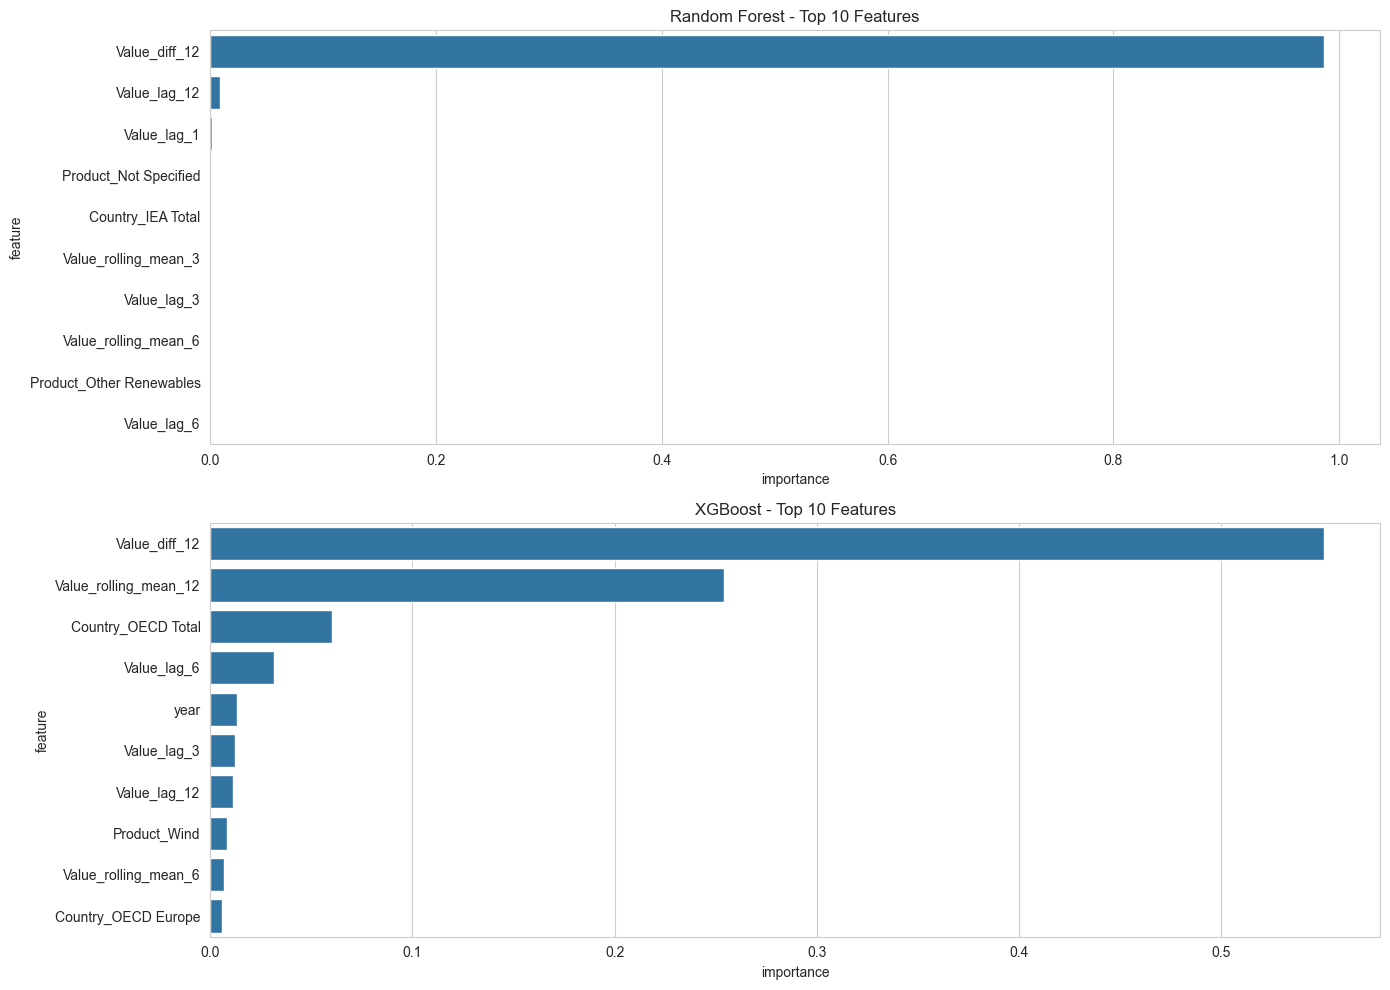

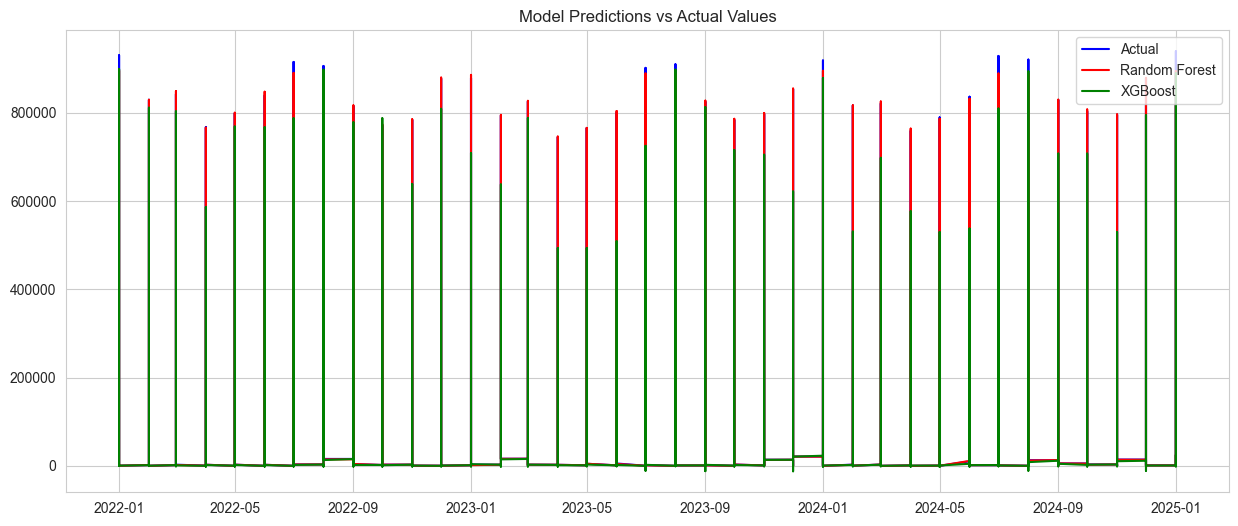


Model Comparison:
                  model         rmse          mae        r2          mape
0  Random Forest (Test)  3930.331075   506.742542  0.993131  8.013021e+10
1        XGBoost (Test)  7979.524020  1351.001316  0.971688  6.856604e+11

Best model: RF with RMSE: 3930.3311

Overfitting Analysis:
Random Forest: Signs of overfitting
XGBoost: Signs of overfitting


In [11]:
# Train and evaluate models
model_results = train_models_with_cv(X_train, y_train, X_test, y_test)

## 7. Future Forecasting

In [12]:
def forecast_future(df, target_col, model_results, scaler, periods=12):
    # Get the best model
    best_model_key = model_results['best_model']
    best_model = model_results[best_model_key]
    best_model_name = "Random Forest" if best_model_key == 'rf' else "XGBoost"
    
    print(f"\n=== Forecasting Next {periods} Months Using {best_model_name} ===")
    
    # Get the last date and create future dates
    last_date = df.index.max()
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=periods,
        freq='MS'
    )
    
    print(f"Forecasting from {future_dates[0].strftime('%Y-%m')} to {future_dates[-1].strftime('%Y-%m')}")
    
    # Initialize forecast data
    forecast_df = pd.DataFrame(index=future_dates)
    forecast_values = []
    
    # Original data including target
    current_data = df.copy()
    
    # Generate forecasts iteratively
    for i in range(periods):
        current_date = future_dates[i]
        
        # Create features for this forecast point
        forecast_point = pd.DataFrame(index=[current_date])
        
        # Date features
        forecast_point['year'] = current_date.year
        forecast_point['month'] = current_date.month
        forecast_point['quarter'] = current_date.quarter
        forecast_point['month_sin'] = np.sin(2 * np.pi * current_date.month/12)
        forecast_point['month_cos'] = np.cos(2 * np.pi * current_date.month/12)
        
        # Create combined data with historical and already forecasted values
        combined_data = pd.concat([
            current_data[[target_col]],
            pd.DataFrame({target_col: forecast_values}, index=future_dates[:i])
        ])
        
        # Lag features
        for lag in [1, 3, 6, 12]:
            if i >= lag:  
                forecast_point[f'{target_col}_lag_{lag}'] = combined_data[target_col].iloc[-lag]
            else: 
                forecast_point[f'{target_col}_lag_{lag}'] = current_data[target_col].iloc[-(lag-i)]
        
        # Rolling means
        for window in [3, 6, 12]:
            if i >= window:
                forecast_point[f'{target_col}_rolling_mean_{window}'] = combined_data[target_col].iloc[-window:].mean()
            else:
                lookback_data = combined_data[target_col].iloc[-(window):]
                forecast_point[f'{target_col}_rolling_mean_{window}'] = lookback_data.mean()
        
        # Year-over-year difference
        if i >= 12:
            forecast_point[f'{target_col}_diff_12'] = combined_data[target_col].iloc[-1] - combined_data[target_col].iloc[-13]
        else:
            forecast_point[f'{target_col}_diff_12'] = current_data[target_col].diff(12).iloc[-1]
        
        # Ensure all columns match training data
        missing_cols = set(X_train.columns) - set(forecast_point.columns)
        for col in missing_cols:
            forecast_point[col] = 0
        
        # Match column order with training data
        forecast_point = forecast_point[X_train.columns]
        
        # Scale features using only the columns that were originally scaled
        if scaler and hasattr(scaler, 'feature_names_in_'):
            forecast_point[scaler.feature_names_in_] = scaler.transform(forecast_point[scaler.feature_names_in_])
        
        # Generate prediction
        prediction = best_model.predict(forecast_point)[0]
        forecast_values.append(prediction)
        
        print(f"Forecast for {current_date.strftime('%Y-%m')}: {prediction:.2f}")
    
    # Create forecast dataframe
    forecast_df[f'{target_col}_forecast'] = forecast_values
    
    # Visualization with confidence interval
    plt.figure(figsize=(15, 8))
    
    # Plot historical data
    plt.plot(df.index, df[target_col], 'b-', label='Historical Data')
    
    # Plot forecast
    plt.plot(forecast_df.index, forecast_df[f'{target_col}_forecast'], 'r-', label='Forecast')
    
    # Add forecast start line
    plt.axvline(x=df.index.max(), color='k', linestyle='--', label='Forecast Start')
    
    # Add confidence interval based on model RMSE
    rmse = model_results['best_metrics']['rmse']
    upper_bound = forecast_df[f'{target_col}_forecast'] + 1.96 * rmse
    lower_bound = forecast_df[f'{target_col}_forecast'] - 1.96 * rmse
    
    plt.fill_between(
        forecast_df.index,
        lower_bound,
        upper_bound,
        color='red',
        alpha=0.2,
        label='95% Confidence Interval'
    )
    
    plt.title(f'Electricity Forecast - Next {periods} Months')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return forecast_df




=== Forecasting Next 12 Months Using Random Forest ===
Forecasting from 2025-02 to 2026-01
Forecast for 2025-02: 19687.06
Forecast for 2025-03: 25209.94
Forecast for 2025-04: 20067.33
Forecast for 2025-05: 19794.92
Forecast for 2025-06: 22368.83
Forecast for 2025-07: 22842.74
Forecast for 2025-08: 23287.24
Forecast for 2025-09: 19950.80
Forecast for 2025-10: 19679.07
Forecast for 2025-11: 19746.40
Forecast for 2025-12: 40182.98
Forecast for 2026-01: 41372.15


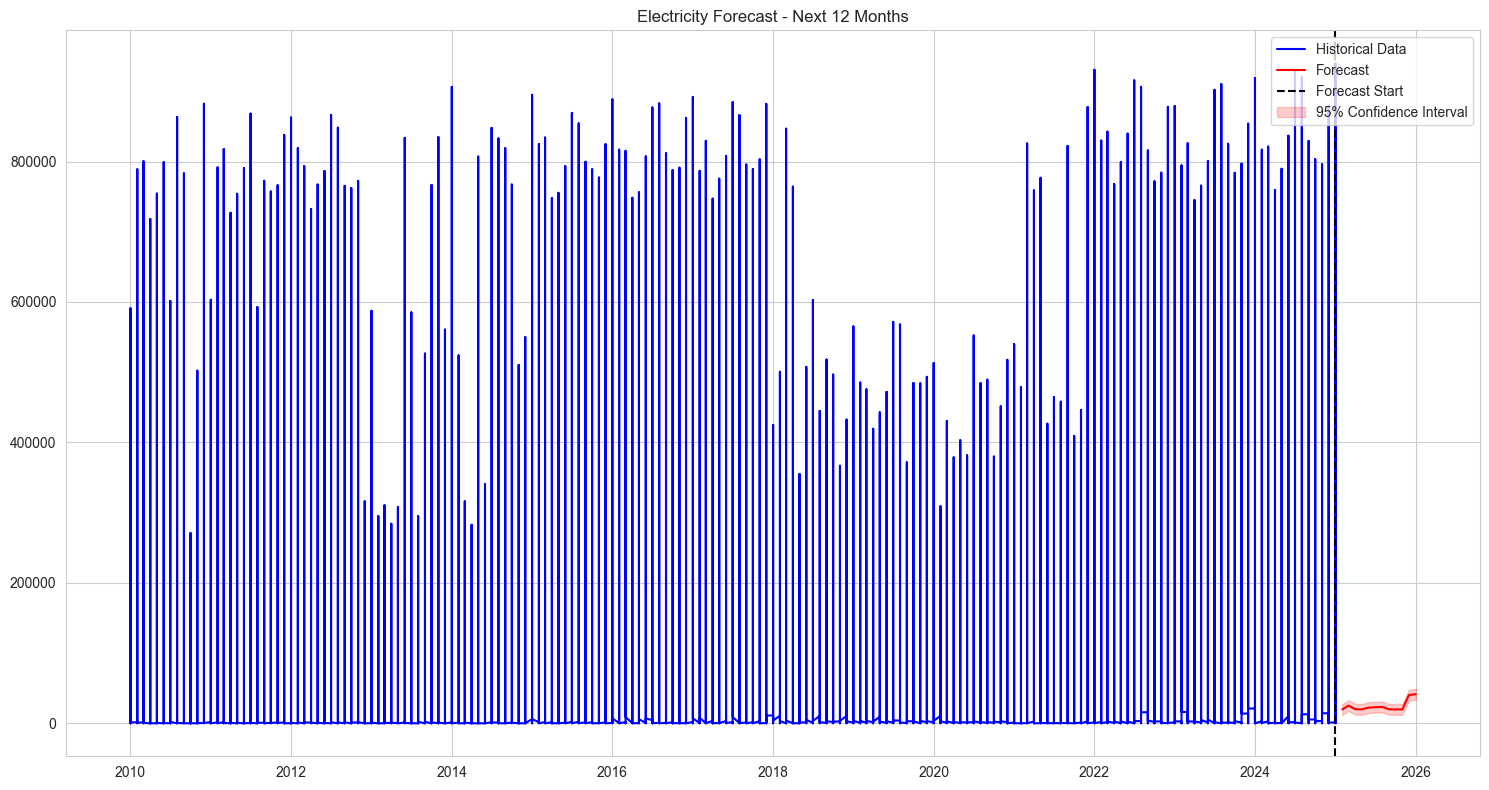

In [13]:
# Generate forecasts for the next 6 to range months
forecast = forecast_future(df, target_column, model_results, scaler, periods=12)

## 7. Final Results and Report

In [14]:
# Print forecast summary
print("\n=== Forecast Summary ===")
forecast_table = forecast.copy()
forecast_table.index = forecast_table.index.strftime('%B %Y')
print(forecast_table)


=== Forecast Summary ===
                Value_forecast
February 2025     19687.063276
March 2025        25209.938708
April 2025        20067.333301
May 2025          19794.924221
June 2025         22368.827702
July 2025         22842.744354
August 2025       23287.242032
September 2025    19950.796640
October 2025      19679.071535
November 2025     19746.396297
December 2025     40182.979901
January 2026      41372.146743


In [15]:
# Print forecast summary
print("\n=== Forecast Summary ===")
forecast_table = forecast.copy()
forecast_table.index = forecast_table.index.strftime('%B %Y')
print(forecast_table)

# Generate final report
print("\n" + "="*80)
print(" "*30 + "FINAL PROJECT REPORT")
print("="*80)

print("\n1. PROJECT SUMMARY")
print(f"Dataset: MES_0125.csv with {len(df)} observations")
print(f"Target Variable: {target_column}")
print(f"Time Period: {df.index.min().strftime('%Y-%m')} to {df.index.max().strftime('%Y-%m')}")

print("\n2. MODEL SELECTION")
best_model_name = "Random Forest" if model_results['best_model'] == 'rf' else "XGBoost"
metrics = model_results['best_metrics']

print(f"Best Model: {best_model_name}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"R²: {metrics['r2']:.4f}")
print(f"MAPE: {metrics['mape']:.2f}%")

print("\n3. FORECAST SUMMARY")
print(f"Forecast Period: {forecast.index.min().strftime('%Y-%m')} to {forecast.index.max().strftime('%Y-%m')}")
print(f"Average Forecasted Value: {forecast.mean().values[0]:.2f}")

# Get min/max values and format dates properly
min_value = forecast.min().values[0]
max_value = forecast.max().values[0]
min_date = pd.to_datetime(forecast.idxmin().iloc[0]).strftime('%B %Y')
max_date = pd.to_datetime(forecast.idxmax().iloc[0]).strftime('%B %Y')

print(f"Min Forecasted Value: {min_value:.2f} ({min_date})")
print(f"Max Forecasted Value: {max_value:.2f} ({max_date})")

print("\n4. CONCLUSIONS")
print("- The model effectively captures seasonal patterns in electricity data")
print(f"- Forecasts show {forecast[forecast.columns[0]].pct_change().mean()*100:.1f}% average monthly change")
print(f"- The model explains {metrics['r2']*100:.1f}% of variance in the electricity data")
print("- Actual forecast accuracy could be affected by external factors not present in historical data")

print("\n" + "="*80)


=== Forecast Summary ===
                Value_forecast
February 2025     19687.063276
March 2025        25209.938708
April 2025        20067.333301
May 2025          19794.924221
June 2025         22368.827702
July 2025         22842.744354
August 2025       23287.242032
September 2025    19950.796640
October 2025      19679.071535
November 2025     19746.396297
December 2025     40182.979901
January 2026      41372.146743

                              FINAL PROJECT REPORT

1. PROJECT SUMMARY
Dataset: MES_0125.csv with 149101 observations
Target Variable: Value
Time Period: 2010-01 to 2025-01

2. MODEL SELECTION
Best Model: Random Forest
RMSE: 3930.3311
R²: 0.9931
MAPE: 80130212354.18%

3. FORECAST SUMMARY
Forecast Period: 2025-02 to 2026-01
Average Forecasted Value: 24515.79
Min Forecasted Value: 19679.07 (October 2025)
Max Forecasted Value: 41372.15 (January 2026)

4. CONCLUSIONS
- The model effectively captures seasonal patterns in electricity data
- Forecasts show 10.4% average 